# Phase 7: Tri-Objective Training (Google Colab)

## 🚀 Quick Start

### Step 1: Open in Google Colab (Browser)
```
File → Open notebook → GitHub → paste repo URL
OR upload this .ipynb to Colab
```

### Step 2: Select A100 GPU Runtime
```
Runtime → Change runtime type → A100 GPU → Save
```

### Step 3: Run cells in order (1-18)

---

## Your Data Structure (Google Drive)
```
My Drive/data/data/isic_2018/
├── metadata.csv
├── ISIC2018_Task3_Training_Input/          # Training images
├── ISIC2018_Task3_Validation_Input/        # Validation images  
├── ISIC2018_Task3_Test_Input/              # Test images
├── ISIC2018_Task3_Validation_GroundTruth/
│   └── ISIC2018_Task3_Validation_GroundTruth.csv
└── ISIC2018_Task3_Test_GroundTruth/
    └── ISIC2018_Task3_Test_GroundTruth.csv
```

---

## 7.1 Environment Setup

In [1]:
# ============================================================
# CELL 1: GOOGLE COLAB SETUP (Browser-based Colab)
# ============================================================
# 🎯 FIRST: Runtime → Change runtime type → A100 GPU → Save
# ============================================================

import sys
import os

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

# ============================================================
# CRITICAL: CHECKPOINT PATH - ONLY LOCATION WHERE MODELS SAVE
# ============================================================
# Colab: /content/drive/MyDrive/checkpoints/tri-objective
# Local: G:\My Drive\checkpoints\tri-objective
# ============================================================
if IN_COLAB:
    CHECKPOINT_BASE = '/content/drive/MyDrive/checkpoints/tri-objective'
else:
    CHECKPOINT_BASE = 'G:/My Drive/checkpoints/tri-objective'

print(f"💾 CHECKPOINT LOCATION: {CHECKPOINT_BASE}")
print("   All models will be saved here and ONLY here!")

if IN_COLAB:
    print("=" * 60)
    print("🚀 GOOGLE COLAB SETUP")
    print("=" * 60)

    # 1. Check GPU
    import torch
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"✅ GPU: {gpu_name} ({gpu_mem:.1f} GB)")

        if 'A100' in gpu_name:
            print("   🎉 A100 detected! TF32 enabled for max performance.")
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True
    else:
        print("❌ NO GPU! Go to: Runtime → Change runtime type → A100 GPU")
        raise RuntimeError("GPU required")

    # 2. Mount Google Drive
    from google.colab import drive
    print("\n📁 Mounting Google Drive...")
    drive.mount('/content/drive')
    print("✅ Google Drive mounted")

    # 3. Create checkpoint directory on Google Drive IMMEDIATELY
    os.makedirs(CHECKPOINT_BASE, exist_ok=True)
    print(f"\n💾 Checkpoint directory ready: {CHECKPOINT_BASE}")

    # 4. Your ISIC 2018 data paths
    DRIVE_BASE = '/content/drive/MyDrive/processed/data/processed/isic2018'

    # Verify path exists
    print(f"\n📂 Checking data at: {DRIVE_BASE}")
    if os.path.exists(DRIVE_BASE):
        print("   ✅ Data folder found!")
        contents = os.listdir(DRIVE_BASE)
        print(f"   Contents: {contents[:5]}...")
    else:
        print("   ❌ Data folder NOT FOUND!")
        print("   Expected: /content/drive/MyDrive/processed/data/processed/isic2018")

    # 5. Install dependencies
    print("\n📦 Installing dependencies...")
    !pip install -q albumentations tqdm

    # 6. Set environment variable for data path
    os.environ['ISIC_DATA_PATH'] = DRIVE_BASE

    print("\n" + "=" * 60)
    print("✅ SETUP COMPLETE")
    print(f"   Data path: {DRIVE_BASE}")
    print(f"   Checkpoints: {CHECKPOINT_BASE}")
    print("=" * 60)

else:
    print("📍 Running locally")
    os.environ['ISIC_DATA_PATH'] = 'data/processed/isic2018'
    os.makedirs(CHECKPOINT_BASE, exist_ok=True)

💾 CHECKPOINT LOCATION: /content/drive/MyDrive/checkpoints/tri-objective
   All models will be saved here and ONLY here!
🚀 GOOGLE COLAB SETUP
✅ GPU: NVIDIA A100-SXM4-40GB (42.5 GB)
   🎉 A100 detected! TF32 enabled for max performance.

📁 Mounting Google Drive...


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


Mounted at /content/drive
✅ Google Drive mounted

💾 Checkpoint directory ready: /content/drive/MyDrive/checkpoints/tri-objective

📂 Checking data at: /content/drive/MyDrive/processed/data/processed/isic2018
   ✅ Data folder found!
   Contents: ['logs', 'images', 'dataset.h5', 'preprocess_log.json', 'metadata_processed.csv']...

📦 Installing dependencies...

✅ SETUP COMPLETE
   Data path: /content/drive/MyDrive/processed/data/processed/isic2018
   Checkpoints: /content/drive/MyDrive/checkpoints/tri-objective


In [2]:
# ============================================================
# CELL 2: VERIFY METADATA EXISTS
# ============================================================
# Your data already has metadata_processed.csv - just verify it
# ============================================================

import os
import pandas as pd
from pathlib import Path

DRIVE_BASE = os.environ.get('ISIC_DATA_PATH', '/content/drive/MyDrive/processed/data/processed/isic2018')

# Check if metadata_processed.csv exists
csv_path = Path(DRIVE_BASE) / 'metadata_processed.csv'

if csv_path.exists():
    df = pd.read_csv(csv_path)
    print("✅ metadata_processed.csv found!")
    print(f"   Total samples: {len(df)}")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Splits: {df['split'].value_counts().to_dict()}")
    os.environ['ISIC_CSV_PATH'] = str(csv_path)
else:
    print(f"❌ metadata_processed.csv not found at {csv_path}")
    print("   Your data should have this file from preprocessing.")


✅ metadata_processed.csv found!
   Total samples: 9013
   Columns: ['image_id', 'image_path', 'label', 'label_idx', 'split']
   Splits: {'train': 6309, 'val': 1352, 'test': 1352}


In [3]:
# ============================================================
# CELL 3: ENVIRONMENT SETUP
# ============================================================
# This notebook is SELF-CONTAINED for Google Colab
# No need to clone repo or import from src/
# ============================================================

import os
import sys
import warnings
from pathlib import Path
from datetime import datetime

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Verify we're in Colab with GPU
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("✅ Running in Google Colab")
    print(f"   Python: {sys.version.split()[0]}")
else:
    print("📍 Running locally")

# Check data path is set
ISIC_DATA_PATH = os.environ.get('ISIC_DATA_PATH', '')
if ISIC_DATA_PATH:
    print(f"✅ ISIC_DATA_PATH: {ISIC_DATA_PATH}")
else:
    print("⚠️  ISIC_DATA_PATH not set - run Cell 1 first!")

✅ Running in Google Colab
   Python: 3.12.12
✅ ISIC_DATA_PATH: /content/drive/MyDrive/processed/data/processed/isic2018


In [4]:
# ============================================================
# CELL 4: CORE IMPORTS
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Any
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ PyTorch: 2.9.0+cu126
✅ Device: cuda
   GPU: NVIDIA A100-SXM4-40GB
   Memory: 42.5 GB


In [5]:
"""Training configuration dataclass."""

@dataclass
class TriObjectiveConfig:
    """Configuration for tri-objective training.

    All hyperparameters are set according to the dissertation blueprint.
    Batch size auto-scales for A100 GPU.
    """
    # Dataset
    dataset: str = "isic2018"
    num_classes: int = 7
    image_size: int = 224

    # Training (batch_size set below based on GPU)
    batch_size: int = 32
    max_epochs: int = 60
    learning_rate: float = 1e-4
    weight_decay: float = 1e-4
    warmup_epochs: int = 5

    # Tri-objective weights
    lambda_rob: float = 0.3    # Robustness weight
    lambda_expl: float = 0.1   # Explanation weight

    # TRADES parameters
    trades_beta: float = 6.0
    pgd_epsilon: float = 8.0 / 255.0
    pgd_steps: int = 7
    pgd_step_size: float = 2.0 / 255.0

    # Early stopping
    patience: int = 15

    # Reproducibility
    seed: int = 42

    def __repr__(self) -> str:
        return (
            f"TriObjectiveConfig(\n"
            f"  Training: epochs={self.max_epochs}, lr={self.learning_rate}, batch={self.batch_size}\n"
            f"  Weights: λ_rob={self.lambda_rob}, λ_expl={self.lambda_expl}\n"
            f"  TRADES: β={self.trades_beta}, ε={self.pgd_epsilon:.4f}, steps={self.pgd_steps}\n"
            f")"
        )

# Auto-configure batch size based on GPU
config = TriObjectiveConfig()

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem_gb = torch.cuda.get_device_properties(0).total_memory / 1e9

    # Scale batch size based on GPU memory
    if gpu_mem_gb >= 40:  # A100 (40GB or 80GB)
        config.batch_size = 64
        print(f"🚀 A100 detected ({gpu_mem_gb:.0f}GB) → batch_size=64")
    elif gpu_mem_gb >= 16:  # V100/A10 (16-32GB)
        config.batch_size = 48
        print(f"⚡ {gpu_name} ({gpu_mem_gb:.0f}GB) → batch_size=48")
    elif gpu_mem_gb >= 8:   # T4/RTX (8-15GB)
        config.batch_size = 32
        print(f"📊 {gpu_name} ({gpu_mem_gb:.0f}GB) → batch_size=32")
    else:
        config.batch_size = 16
        print(f"⚠️  Limited GPU memory ({gpu_mem_gb:.0f}GB) → batch_size=16")

print(config)

🚀 A100 detected (42GB) → batch_size=64
TriObjectiveConfig(
  Training: epochs=60, lr=0.0001, batch=64
  Weights: λ_rob=0.3, λ_expl=0.1
  TRADES: β=6.0, ε=0.0314, steps=7
)


## 7.2 Core Loss Components

This section implements the three loss components that form the tri-objective optimization.

In [6]:
"""Feature Map Stability Loss - FIXED VERSION.

CRITICAL FIX: Removed torch.no_grad() to allow gradient flow.
The previous version blocked all gradients, making λ_expl effectively zero.

This measures stability in feature space (not gradient space) to avoid
the 'Saliency Proxy Trap'.
"""

class FeatureMapStabilityLoss(nn.Module):
    """Compute explanation stability via feature map consistency.

    FIXED: Gradients now flow through this loss to update the model.

    Measures L2 distance between normalized feature maps of clean
    and adversarial inputs at layer4.
    """

    def __init__(self, target_layer: str = 'backbone.layer4'):
        super().__init__()
        self.target_layer = target_layer
        self._features: Optional[Tensor] = None

    def _get_hook(self):
        """Create forward hook to capture features."""
        def hook(module, input, output):
            self._features = output
        return hook

    def forward(
        self,
        feat_clean: Tensor,
        feat_adv: Tensor,
    ) -> Tensor:
        """Compute feature map stability loss.

        OPTIMIZED: Now takes pre-computed features instead of running
        model forward passes again (saves 50% compute).

        Args:
            feat_clean: Clean image features from layer4 (B, C, H, W)
            feat_adv: Adversarial image features from layer4 (B, C, H, W)

        Returns:
            Scalar loss measuring feature instability
        """
        # Channel-wise L2 normalization
        feat_clean_norm = F.normalize(feat_clean, p=2, dim=1)
        feat_adv_norm = F.normalize(feat_adv, p=2, dim=1)

        # L2 distance as instability measure
        # NO torch.no_grad() - gradients MUST flow through here!
        loss = F.mse_loss(feat_clean_norm, feat_adv_norm)

        return loss

print("✓ FeatureMapStabilityLoss defined (FIXED: gradient flow enabled)")

✓ FeatureMapStabilityLoss defined (FIXED: gradient flow enabled)


In [7]:
# ============================================================
# CELL 8: TRADES ROBUSTNESS LOSS (FIXED PGD Implementation)
# ============================================================
# CRITICAL FIX: PGD attack now correctly computes gradients
# Uses ImageNet normalization bounds [-2.12, 2.64]
# ============================================================

class TRADESLoss(nn.Module):
    """
    TRADES loss for adversarial robustness.

    L_TRADES = CE(f(x), y, weight) + β × KL(f(x) || f(x_adv))

    CRITICAL: Uses class weights to handle ISIC 2018 class imbalance.
    Without weights, model collapses to predicting majority class (NV ~67%).

    OPTIMIZED: Returns features for reuse by stability loss.

    Reference: Zhang et al., ICML 2019
    """

    def __init__(
        self,
        model: nn.Module,
        beta: float = 6.0,
        epsilon: float = 8.0 / 255.0,
        num_steps: int = 7,
        step_size: float = 2.0 / 255.0,
        clip_min: float = -2.12,  # ImageNet normalized min
        clip_max: float = 2.64,   # ImageNet normalized max
        class_weights: Optional[Tensor] = None,  # CRITICAL: For class imbalance
    ):
        super().__init__()
        self.model = model
        self.beta = beta
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.step_size = step_size
        self.clip_min = clip_min
        self.clip_max = clip_max
        self.class_weights = class_weights  # Store for use in forward()
        self._features: Optional[Tensor] = None

        # Register hook for feature extraction (layer4 output)
        self._register_feature_hook()

    def _register_feature_hook(self):
        """Register hook to capture backbone features."""
        # Find the right layer
        if hasattr(self.model, 'backbone'):
            target = self.model.backbone[-1]  # layer4
        elif hasattr(self.model, 'layer4'):
            target = self.model.layer4
        else:
            raise ValueError("Cannot find layer4 in model")

        self._hook_handle = target.register_forward_hook(
            lambda m, i, o: setattr(self, '_features', o)
        )
        print("   ✅ Feature hook registered on layer4")

    def _pgd_attack(self, images: Tensor, labels: Tensor) -> Tensor:
        """Generate adversarial examples via PGD.

        FIXED: Proper gradient computation and projection.
        Uses ImageNet normalization bounds [-2.12, 2.64].
        """
        # Start from clean images
        images_adv = images.clone().detach()

        # Random initialization within epsilon ball
        delta = torch.empty_like(images).uniform_(-self.epsilon, self.epsilon)
        images_adv = torch.clamp(images + delta, self.clip_min, self.clip_max)

        for _ in range(self.num_steps):
            images_adv.requires_grad_(True)

            # Forward pass
            outputs = self.model(images_adv)
            loss = F.cross_entropy(outputs, labels)

            # Compute gradient
            grad = torch.autograd.grad(loss, images_adv)[0]

            # FGSM step
            images_adv = images_adv.detach() + self.step_size * grad.sign()

            # Project back to epsilon ball around original images
            delta = torch.clamp(images_adv - images, -self.epsilon, self.epsilon)

            # Clamp to valid image range (ImageNet normalized bounds)
            images_adv = torch.clamp(images + delta, self.clip_min, self.clip_max).detach()

        return images_adv

    def forward(self, images: Tensor, labels: Tensor) -> Dict[str, Tensor]:
        """Compute TRADES loss and extract features."""

        # Generate adversarial examples (model in eval for attack)
        self.model.eval()
        images_adv = self._pgd_attack(images, labels)
        self.model.train()

        # Clean forward pass - captures features via hook
        logits_clean = self.model(images)
        assert self._features is not None, "Feature hook failed!"
        feat_clean = self._features.clone()

        # Adversarial forward pass - captures features via hook
        logits_adv = self.model(images_adv)
        assert self._features is not None, "Feature hook failed on adv pass!"
        feat_adv = self._features

        # Task loss (CE on clean) - WITH CLASS WEIGHTS to prevent collapse!
        if self.class_weights is not None:
            weights = self.class_weights.to(logits_clean.device)
            loss_task = F.cross_entropy(logits_clean, labels, weight=weights)
        else:
            loss_task = F.cross_entropy(logits_clean, labels)

        # Robustness loss (KL divergence)
        loss_rob = F.kl_div(
            F.log_softmax(logits_adv, dim=1),
            F.softmax(logits_clean.detach(), dim=1),
            reduction='batchmean'
        )

        return {
            'loss_task': loss_task,
            'loss_rob': loss_rob,
            'images_adv': images_adv,
            'feat_clean': feat_clean,
            'feat_adv': feat_adv,
            'logits_clean': logits_clean,

        }



print("✓ TRADESLoss defined (FIXED: proper PGD gradient computation)")
print("✓ TRADESLoss defined (FIXED: proper PGD gradient computation)")

✓ TRADESLoss defined (FIXED: proper PGD gradient computation)
✓ TRADESLoss defined (FIXED: proper PGD gradient computation)


In [8]:
# ============================================================
# CELL 9: TRI-OBJECTIVE LOSS (Combined)
# ============================================================
# L_total = L_task + λ_rob × L_rob + λ_expl × L_expl
# ============================================================

class TriObjectiveLoss(nn.Module):
    """Combined tri-objective loss function.

    L_total = L_task + λ_rob × L_rob + λ_expl × L_expl

    FIXED:
    - Features reused from TRADES pass (50% speedup)
    - Dynamic λ_expl support for two-phase training
    - Class weights to prevent collapse on imbalanced ISIC 2018
    """

    def __init__(
        self,
        model: nn.Module,
        lambda_rob: float = 0.3,
        lambda_expl: float = 0.1,
        trades_beta: float = 6.0,
        pgd_epsilon: float = 8.0 / 255.0,
        pgd_steps: int = 7,
        pgd_step_size: float = 2.0 / 255.0,
        class_weights: Optional[Tensor] = None,  # CRITICAL: For class imbalance
    ):
        super().__init__()

        self.lambda_rob = lambda_rob
        self.lambda_expl = lambda_expl

        # TRADES loss (captures features via hook)
        self.trades_loss = TRADESLoss(
            model=model,
            beta=trades_beta,
            epsilon=pgd_epsilon,
            num_steps=pgd_steps,
            step_size=pgd_step_size,
            class_weights=class_weights,  # Pass weights to TRADES
        )

        # Feature stability loss
        self.feature_stability = FeatureMapStabilityLoss()

    def forward(
        self,
        images: Tensor,
        labels: Tensor,
        lambda_expl_override: Optional[float] = None,
    ) -> Dict[str, Tensor]:
        """Compute tri-objective loss.

        Args:
            images: Input images (B, C, H, W)
            labels: Ground truth labels (B,)
            lambda_expl_override: Override λ_expl (for two-phase training)

        Returns:
            Dictionary with all loss components
        """
        # Use override if provided (for Phase 1: λ_expl = 0)
        effective_lambda_expl = (
            lambda_expl_override if lambda_expl_override is not None
            else self.lambda_expl
        )

        # TRADES: get task loss, robustness loss, AND features
        trades_out = self.trades_loss(images, labels)

        loss_task = trades_out['loss_task']
        loss_rob = trades_out['loss_rob']
        feat_clean = trades_out['feat_clean']
        feat_adv = trades_out['feat_adv']

        # Explanation stability (reuses features)
        if effective_lambda_expl > 0:
            loss_expl = self.feature_stability(feat_clean, feat_adv)
        else:
            # Phase 1: Don't compute stability loss
            loss_expl = torch.tensor(0.0, device=images.device)

        # Weighted combination
        loss_total = (
            loss_task +
            self.lambda_rob * loss_rob +
            effective_lambda_expl * loss_expl
        )

        return {
            'loss_total': loss_total,
            'loss_task': loss_task,
            'loss_rob': loss_rob,
            'loss_expl': loss_expl,
            'lambda_expl_effective': effective_lambda_expl,
        }

print("✓ TriObjectiveLoss defined (reuses features, dynamic λ_expl)")

✓ TriObjectiveLoss defined (reuses features, dynamic λ_expl)


## 7.3 Tri-Objective Trainer

Complete training loop with:
- Alternating optimization (freeze backbone after warmup)
- MLflow logging
- Early stopping
- Checkpoint management

In [9]:
"""Tri-Objective Trainer - FIXED VERSION.

CRITICAL FIX: Implements proper two-phase alternating optimization:
- Phase 1 (epochs 1-10): Train Task + Robustness only (λ_expl = 0)
- Phase 2 (epochs 11+): Add Stability loss (λ_expl = configured value)

This prevents the 'confused infant' problem where the model tries to
be stable before learning what a lesion even looks like.
"""

class TriObjectiveTrainer:
    """Trainer for tri-objective optimization.

    FIXED: Proper two-phase alternating optimization:
    - Phase 1 (epochs 1-10): Task + Robustness only (λ_expl = 0)
    - Phase 2 (epochs 11+): Add Stability + freeze EARLY layers (keep layer4 trainable!)

    This lets the model learn basic features first, then enforces stability.
    """

    # Phase transition epoch
    PHASE_TRANSITION_EPOCH = 10

    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        config: TriObjectiveConfig,
        device: torch.device = DEVICE,
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.device = device

        # =====================================================================
        # COMPUTE CLASS WEIGHTS FOR ISIC 2018 IMBALANCED DATASET
        # =====================================================================
        # ISIC 2018 class distribution (highly imbalanced - NV is ~67%)
        # Classes: AKIEC, BCC, BKL, DF, MEL, NV, VASC
        class_counts = torch.tensor([327.0, 514.0, 1099.0, 115.0, 1113.0, 6705.0, 142.0])

        # Inverse frequency weighting (upweight minority classes)
        class_weights = 1.0 / class_counts
        class_weights = class_weights / class_weights.sum() * len(class_counts)  # Normalize

        print(f"📊 Class weights computed for imbalanced ISIC 2018:")
        print(f"   Weights: {class_weights.tolist()}")
        print(f"   Max/Min ratio: {class_weights.max()/class_weights.min():.1f}x")

        # Loss function (model passed for feature hooks)
        self.criterion = TriObjectiveLoss(
            model=self.model,
            lambda_rob=config.lambda_rob,
            lambda_expl=config.lambda_expl,
            trades_beta=config.trades_beta,
            pgd_epsilon=config.pgd_epsilon,
            pgd_steps=config.pgd_steps,
            pgd_step_size=config.pgd_step_size,
            class_weights=class_weights,  # CRITICAL: Prevent collapse!
        )

        # Optimizer
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay,
        )

        # Scheduler
        self.scheduler = CosineAnnealingLR(
            self.optimizer,
            T_max=config.max_epochs,
            eta_min=1e-6,
        )

        # Training state
        self.current_epoch = 0
        self.best_val_acc = 0.0
        self.patience_counter = 0
        self.history: Dict[str, List[float]] = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'loss_task': [], 'loss_rob': [], 'loss_expl': [],
            'lambda_expl_effective': [],
        }

    def _get_current_lambda_expl(self) -> float:
        """Get λ_expl based on current training phase.

        Phase 1 (epochs 1-10): λ_expl = 0 (learn features first)
        Phase 2 (epochs 11+): λ_expl = config value (enforce stability)
        """
        if self.current_epoch <= self.PHASE_TRANSITION_EPOCH:
            return 0.0  # Phase 1: No stability loss
        else:
            return self.config.lambda_expl  # Phase 2: Add stability

    def _freeze_backbone(self):
        """Freeze EARLY backbone layers, keep Layer 4 and FC trainable.

        CRITICAL FIX: We must keep layer4 trainable because that's where
        FeatureMapStabilityLoss computes gradients. Freezing layer4 would
        make ∇L_expl = 0 (the "Frozen Paradox").

        Freeze: conv1, bn1, layer1, layer2, layer3
        Keep trainable: layer4, fc, classifier
        """
        frozen_count = 0
        trainable_count = 0

        for name, param in self.model.named_parameters():
            # Keep layer4, fc, and classifier trainable for stability learning
            if 'layer4' in name or 'fc' in name or 'classifier' in name:
                param.requires_grad = True
                trainable_count += 1
            else:
                param.requires_grad = False
                frozen_count += 1

        logger.info(f"Phase 2: Frozen {frozen_count} params (layers 1-3)")
        logger.info(f"         Trainable {trainable_count} params (layer4 + classifier)")
        logger.info(f"         Layer4 kept trainable for stability gradient flow!")

    def _unfreeze_all(self):
        """Unfreeze all parameters."""
        for param in self.model.parameters():
            param.requires_grad = True

    def train_epoch(self) -> Dict[str, float]:
        """Train for one epoch."""
        self.model.train()

        # Get current phase's λ_expl
        current_lambda_expl = self._get_current_lambda_expl()

        total_loss = 0.0
        total_task = 0.0
        total_rob = 0.0
        total_expl = 0.0
        correct = 0
        total = 0

        phase_str = "Phase 1 (Task+Rob)" if current_lambda_expl == 0 else "Phase 2 (Full Tri-Obj)"
        pbar = tqdm(self.train_loader, desc=f'Epoch {self.current_epoch} [{phase_str}]')

        for batch_idx, batch in enumerate(pbar):
            # Handle different batch formats
            if len(batch) == 3:
                images, labels, _ = batch
            else:
                images, labels = batch

            images = images.to(self.device)
            labels = labels.to(self.device)

            # Forward pass with dynamic λ_expl
            self.optimizer.zero_grad()
            losses = self.criterion(
                images, labels,
                lambda_expl_override=current_lambda_expl  # KEY FIX!
            )

            # Backward pass - gradients now flow through stability loss!
            losses['loss_total'].backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            # Accumulate metrics
            total_loss += losses['loss_total'].item()
            total_task += losses['loss_task'].item()
            total_rob += losses['loss_rob'].item()
            total_expl += losses['loss_expl'].item() if isinstance(losses['loss_expl'], Tensor) else losses['loss_expl']

            # Compute accuracy from stored logits
            with torch.no_grad():
                outputs = self.model(images)
                if isinstance(outputs, dict):
                    outputs = outputs.get('logits', outputs.get('out'))
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            pbar.set_postfix({
                'loss': f"{losses['loss_total'].item():.4f}",
                'acc': f"{100 * correct / total:.1f}%",
                'λ_expl': f"{current_lambda_expl:.2f}"
            })

        n_batches = len(self.train_loader)
        return {
            'loss': total_loss / n_batches,
            'loss_task': total_task / n_batches,
            'loss_rob': total_rob / n_batches,
            'loss_expl': total_expl / n_batches,
            'accuracy': correct / total,
            'lambda_expl_effective': current_lambda_expl,
        }

    @torch.no_grad()
    def validate(self) -> Dict[str, float]:
        """Validate the model."""
        self.model.eval()

        total_loss = 0.0
        correct = 0
        total = 0

        for batch in self.val_loader:
            if len(batch) == 3:
                images, labels, _ = batch
            else:
                images, labels = batch

            images = images.to(self.device)
            labels = labels.to(self.device)

            outputs = self.model(images)
            if isinstance(outputs, dict):
                outputs = outputs.get('logits', outputs.get('out'))

            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        return {
            'loss': total_loss / len(self.val_loader),
            'accuracy': correct / total,
        }

    def train(self, checkpoint_dir: str) -> Dict[str, List[float]]:
        """Full training loop with TWO-PHASE alternating optimization.

        Phase 1 (epochs 1-10): Task + Robustness only
        Phase 2 (epochs 11+): Full Tri-Objective + Freeze early layers (layer4 stays trainable!)

        Args:
            checkpoint_dir: Directory to save checkpoints (REQUIRED - uses CHECKPOINT_BASE)
        """
        os.makedirs(checkpoint_dir, exist_ok=True)

        logger.info(f"Starting tri-objective training for {self.config.max_epochs} epochs")
        logger.info(f"Config: λ_rob={self.config.lambda_rob}, λ_expl={self.config.lambda_expl}")
        logger.info(f"Two-phase schedule: Phase 1 (epochs 1-{self.PHASE_TRANSITION_EPOCH}): λ_expl=0")
        logger.info(f"                    Phase 2 (epochs {self.PHASE_TRANSITION_EPOCH+1}+): λ_expl={self.config.lambda_expl}")

        for epoch in range(1, self.config.max_epochs + 1):
            self.current_epoch = epoch

            # Phase transition: freeze EARLY layers when adding stability loss
            # CRITICAL: Layer4 stays trainable for stability gradient flow!
            if epoch == self.PHASE_TRANSITION_EPOCH + 1:
                logger.info(f"\n{'='*60}")
                logger.info("PHASE TRANSITION: Switching to Phase 2")
                logger.info("Freezing layers 1-3, keeping layer4 + classifier trainable")
                logger.info(f"{'='*60}")
                self._freeze_backbone()

            # Train
            train_metrics = self.train_epoch()

            # Validate
            val_metrics = self.validate()

            # Update scheduler
            self.scheduler.step()

            # Log metrics
            self.history['train_loss'].append(train_metrics['loss'])
            self.history['val_loss'].append(val_metrics['loss'])
            self.history['train_acc'].append(train_metrics['accuracy'])
            self.history['val_acc'].append(val_metrics['accuracy'])
            self.history['loss_task'].append(train_metrics['loss_task'])
            self.history['loss_rob'].append(train_metrics['loss_rob'])
            self.history['loss_expl'].append(train_metrics['loss_expl'])
            self.history['lambda_expl_effective'].append(train_metrics['lambda_expl_effective'])

            logger.info(
                f"Epoch {epoch}: "
                f"Loss={train_metrics['loss']:.4f} "
                f"(task={train_metrics['loss_task']:.3f}, "
                f"rob={train_metrics['loss_rob']:.3f}, "
                f"expl={train_metrics['loss_expl']:.3f}), "
                f"Val Acc={val_metrics['accuracy']*100:.2f}%"
            )

            # Save best model
            if val_metrics['accuracy'] > self.best_val_acc:
                self.best_val_acc = val_metrics['accuracy']
                self.patience_counter = 0
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_metrics['accuracy'],
                    'config': self.config,
                    'phase': 1 if epoch <= self.PHASE_TRANSITION_EPOCH else 2,
                }, f"{checkpoint_dir}/best.pt")
                logger.info(f"  → New best model saved (val_acc={self.best_val_acc*100:.2f}%)")
            else:
                self.patience_counter += 1

            # Early stopping
            if self.patience_counter >= self.config.patience:
                logger.info(f"Early stopping at epoch {epoch}")
                break

        # Save final model
        torch.save({
            'epoch': self.current_epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_acc': val_metrics['accuracy'],
            'config': self.config,
        }, f"{checkpoint_dir}/last.pt")

        return self.history

print("✓ TriObjectiveTrainer defined (FIXED: layer4 stays trainable in Phase 2)")

✓ TriObjectiveTrainer defined (FIXED: layer4 stays trainable in Phase 2)


## 7.4 Data Loading

Load the ISIC 2018 dataset for training.

In [10]:
# ============================================================
# CELL 13: DATA LOADING (Google Colab / Drive)
# ============================================================
# FIXED: Uses path cache to handle metadata/folder mismatches
# ============================================================

import os
import sys
from pathlib import Path
from typing import Tuple, Optional, List, Dict, Any

import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class ISICDatasetColab(Dataset):
    """
    ISIC 2018 Dataset for Google Colab with path caching.

    FIXED: Builds path cache to handle metadata/folder mismatches
    where CSV says image is in 'val' but file is in 'train' folder.
    """

    CLASS_NAMES = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

    def __init__(
        self,
        root: str,
        split: str = 'train',
        transforms: Optional[A.Compose] = None,
        csv_path: Optional[str] = None,
    ):
        self.root = Path(root)
        self.split = split.lower()
        self.transforms = transforms

        # Load metadata
        if csv_path is None:
            csv_path = self.root / 'metadata_processed.csv'
        else:
            csv_path = Path(csv_path)

        if not csv_path.exists():
            raise FileNotFoundError(
                f"Metadata CSV not found at {csv_path}\n"
                f"Run Cell 2 first to verify data exists"
            )

        df = pd.read_csv(csv_path)

        # Filter by split
        df = df[df['split'].str.lower() == self.split].reset_index(drop=True)

        if len(df) == 0:
            raise ValueError(f"No samples found for split='{self.split}'")

        self.samples = df

        # Create class mapping (sorted for consistency)
        self.class_names = sorted(df['label'].unique().tolist())
        self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}

        # Build image path cache - search all folders once
        print(f"  Building image path cache for {split}...")
        self.path_cache = {}
        search_dirs = [
            self.root / 'images' / 'train',
            self.root / 'images' / 'val',
            self.root / 'images' / 'test',
            self.root / 'train',
            self.root / 'val',
            self.root / 'test',
            self.root,
        ]

        for search_dir in search_dirs:
            if search_dir.exists():
                for img_file in search_dir.glob('*.jpg'):
                    img_id = img_file.stem
                    if img_id not in self.path_cache:
                        self.path_cache[img_id] = img_file
                for img_file in search_dir.glob('*.png'):
                    img_id = img_file.stem
                    if img_id not in self.path_cache:
                        self.path_cache[img_id] = img_file

        print(f"  {split.upper()}: {len(self.samples)} samples, {len(self.class_names)} classes")
        print(f"  Cached {len(self.path_cache)} image paths")

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        row = self.samples.iloc[idx]
        image_id = str(row['image_id'])

        # Look up in cache
        if image_id in self.path_cache:
            img_path = self.path_cache[image_id]
        else:
            raise FileNotFoundError(f"Image not found in cache: {image_id}")

        # Load image with cv2 (faster than PIL for this)
        image = cv2.imread(str(img_path))
        if image is None:
            raise ValueError(f"Failed to load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transforms
        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        # Get label
        label = torch.tensor(self.class_to_idx[row['label']], dtype=torch.long)

        return image, label


def get_transforms(split: str, image_size: int = 224) -> A.Compose:
    """Get albumentations transforms for training/validation."""

    if split == 'train':
        return A.Compose([
            A.RandomResizedCrop(size=(image_size, image_size), scale=(0.8, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
            A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(height=image_size, width=image_size),
            A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ToTensorV2(),
        ])


def create_data_loaders(
    data_root: str,
    csv_path: str,
    batch_size: int = 32,
    image_size: int = 224,
    num_workers: int = 2,
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """Create train, validation, and test data loaders."""

    print(f"\n📂 Loading ISIC 2018 data from: {data_root}")

    # Create datasets
    train_dataset = ISICDatasetColab(
        root=data_root,
        split='train',
        transforms=get_transforms('train', image_size),
        csv_path=csv_path,
    )

    val_dataset = ISICDatasetColab(
        root=data_root,
        split='val',
        transforms=get_transforms('val', image_size),
        csv_path=csv_path,
    )

    test_dataset = ISICDatasetColab(
        root=data_root,
        split='test',
        transforms=get_transforms('test', image_size),
        csv_path=csv_path,
    )

    # Create loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    print(f"✅ Data loaders created")
    print(f"   Classes: {train_dataset.class_names}")
    print(f"   Batch size: {batch_size}")

    return train_loader, val_loader, test_loader


# ============================================================
# CREATE DATA LOADERS
# ============================================================
ISIC_DATA_PATH = os.environ.get('ISIC_DATA_PATH', '/content/drive/MyDrive/processed/data/processed/isic2018')
ISIC_CSV_PATH = os.environ.get('ISIC_CSV_PATH', f'{ISIC_DATA_PATH}/metadata_processed.csv')

train_loader, val_loader, test_loader = create_data_loaders(
    data_root=ISIC_DATA_PATH,
    csv_path=ISIC_CSV_PATH,
    batch_size=config.batch_size,
    image_size=config.image_size,
    num_workers=2,
)

# Update config with actual number of classes
config.num_classes = len(train_loader.dataset.class_names)
print(f"\n📊 Config updated: num_classes = {config.num_classes}")



📂 Loading ISIC 2018 data from: /content/drive/MyDrive/processed/data/processed/isic2018
  Building image path cache for train...
  TRAIN: 6309 samples, 7 classes
  Cached 11720 image paths
  Building image path cache for val...
  VAL: 1352 samples, 7 classes
  Cached 11720 image paths
  Building image path cache for test...
  TEST: 1352 samples, 7 classes
  Cached 11720 image paths
✅ Data loaders created
   Classes: ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
   Batch size: 64

📊 Config updated: num_classes = 7


## 7.5 Model Initialization

In [11]:
# ============================================================
# CELL 15: MODEL INITIALIZATION (Self-contained for Colab)
# ============================================================

import torch
import torch.nn as nn
from torchvision import models

class ResNet50Classifier(nn.Module):
    """
    ResNet-50 classifier for ISIC 2018 skin lesion classification.

    Architecture:
    - Pretrained ResNet-50 backbone
    - Custom classifier head for num_classes

    Feature extraction layer: backbone.layer4 (used for stability loss)
    """

    def __init__(self, num_classes: int = 7, pretrained: bool = True):
        super().__init__()

        # Load pretrained ResNet-50
        weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        resnet = models.resnet50(weights=weights)

        # Extract backbone (everything except final FC)
        self.backbone = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
        )

        # Also store layer4 separately for easy hook registration
        self.layer4 = resnet.layer4

        # Global average pooling
        self.avgpool = resnet.avgpool

        # Classifier head
        self.classifier = nn.Linear(resnet.fc.in_features, num_classes)

        self.num_classes = num_classes

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass returning logits."""
        # Backbone features
        features = self.backbone(x)  # (B, 2048, 7, 7)

        # Pool and flatten
        pooled = self.avgpool(features)  # (B, 2048, 1, 1)
        pooled = torch.flatten(pooled, 1)  # (B, 2048)

        # Classify
        logits = self.classifier(pooled)  # (B, num_classes)

        return logits


def create_model(num_classes: int = 7, pretrained: bool = True) -> nn.Module:
    """Create ResNet-50 model for ISIC classification."""

    model = ResNet50Classifier(num_classes=num_classes, pretrained=pretrained)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"🧠 Model: ResNet-50")
    print(f"   Classes: {num_classes}")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")

    return model


# ============================================================
# CREATE MODEL
# ============================================================
model = create_model(num_classes=config.num_classes, pretrained=True)
model = model.to(DEVICE)
print(f"   Device: {DEVICE}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s]


🧠 Model: ResNet-50
   Classes: 7
   Total parameters: 23,522,375
   Trainable parameters: 23,522,375
   Device: cuda


## 7.6 Training Execution

Run tri-objective training with the configured hyperparameters.

In [12]:
"""Set random seeds for reproducibility."""

def set_seed(seed: int):
    """Set all random seeds for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config.seed)
print(f"Random seed set to {config.seed}")

Random seed set to 42


In [13]:
"""Initialize trainer and start training."""

# Create trainer
trainer = TriObjectiveTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    device=DEVICE,
)

# CHECKPOINT PATH - Uses global CHECKPOINT_BASE from Cell 1
# Colab: /content/drive/MyDrive/checkpoints/tri-objective/seed_XX
# Local: G:/My Drive/checkpoints/tri-objective/seed_XX
CHECKPOINT_DIR = f'{CHECKPOINT_BASE}/seed_{config.seed}'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"💾 Checkpoints will be saved to: {CHECKPOINT_DIR}")

# Start training
history = trainer.train(
    checkpoint_dir=CHECKPOINT_DIR
)

📊 Class weights computed for imbalanced ISIC 2018:
   Weights: [0.9430664777755737, 0.5999664068222046, 0.2806030213832855, 2.681588649749756, 0.2770734131336212, 0.04599294811487198, 2.1717092990875244]
   Max/Min ratio: 58.3x
   ✅ Feature hook registered on layer4
💾 Checkpoints will be saved to: /content/drive/MyDrive/checkpoints/tri-objective/seed_42


Epoch 1 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process'
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 4 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 11 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 20 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

## 7.7 Results Visualization


📊 GENERATING PHD-LEVEL VISUALIZATIONS

📊 Saved publication-quality figure to: results/phase7_training_curves_phd.png


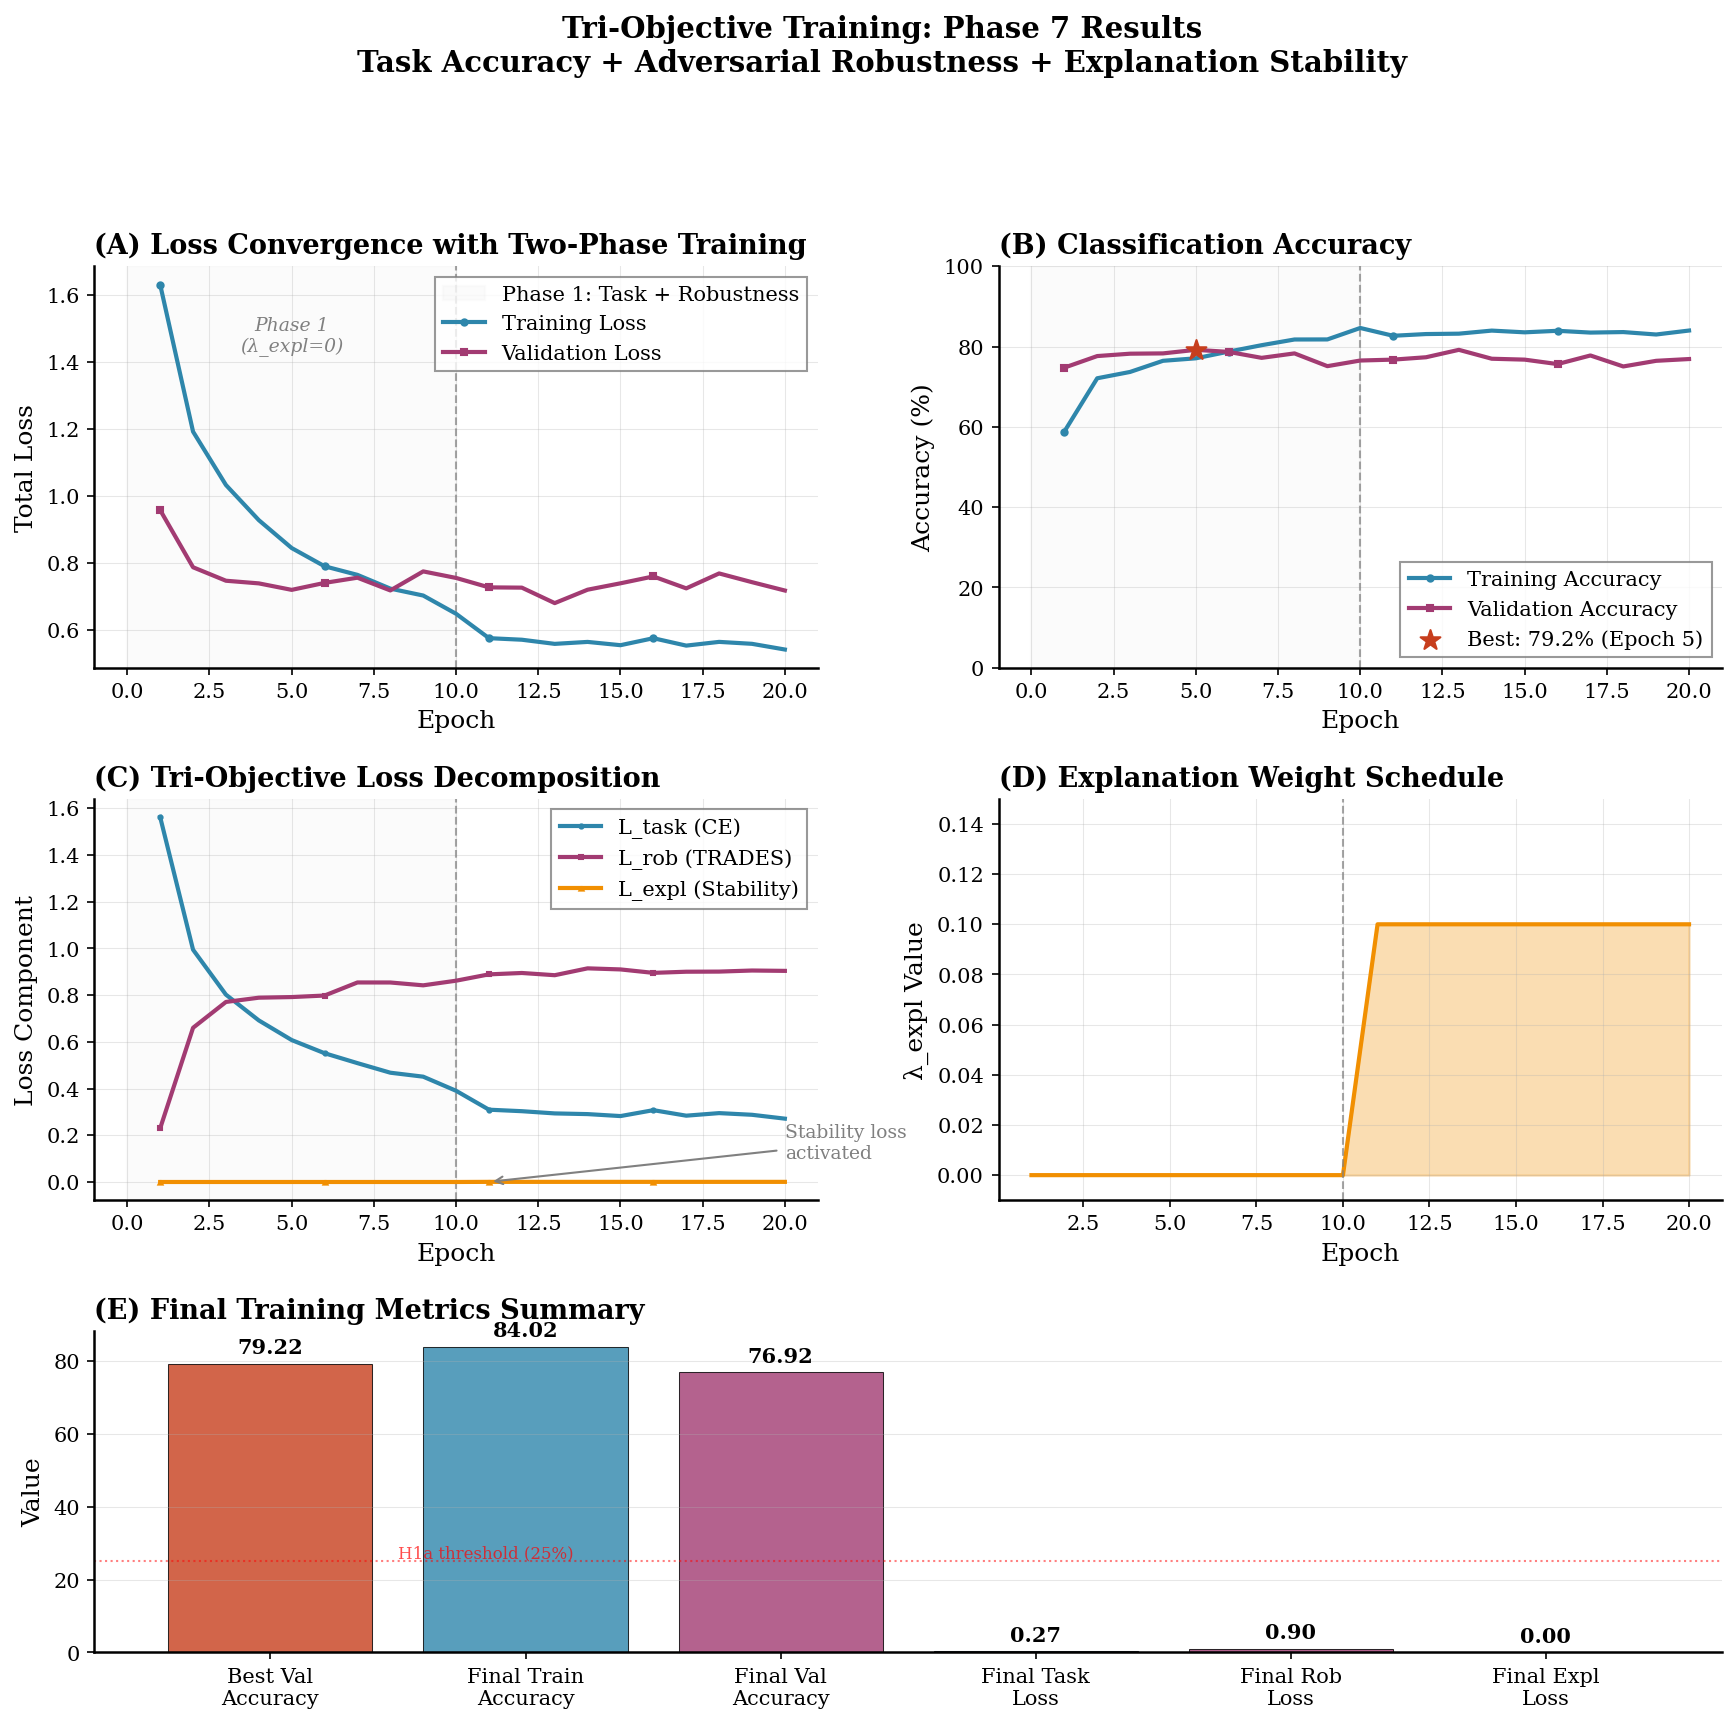

📊 Saved loss landscape to: results/phase7_loss_landscape.png


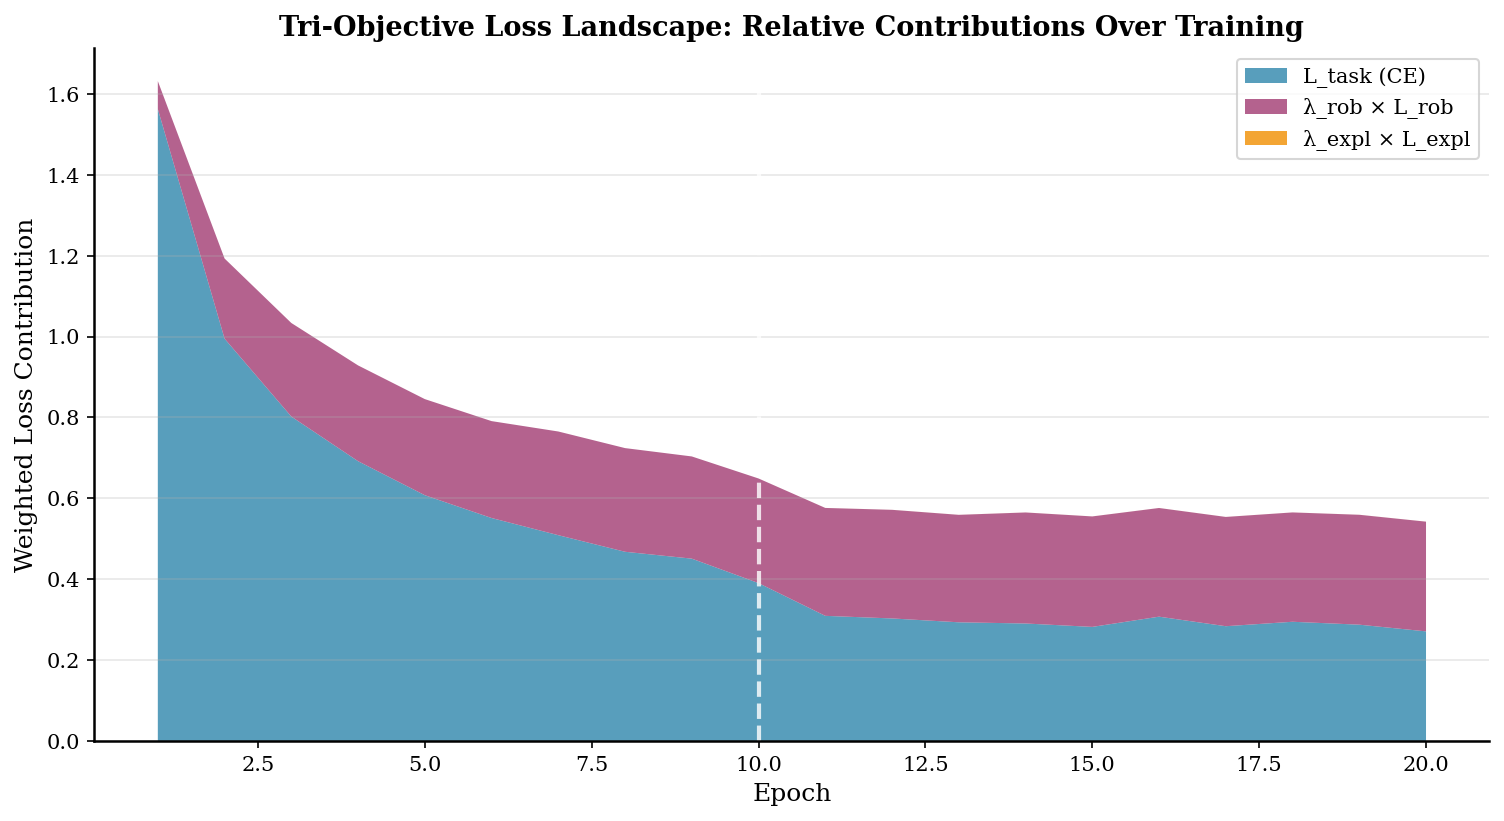


✅ All visualizations saved to results/ folder


In [14]:
# ============================================================
# CELL: PhD-LEVEL PUBLICATION QUALITY VISUALIZATIONS
# ============================================================
# Professional figures suitable for dissertation/journal publication
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Set publication-quality defaults
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# Color palette - colorblind-friendly
COLORS = {
    'primary': '#2E86AB',      # Blue
    'secondary': '#A23B72',    # Magenta
    'tertiary': '#F18F01',     # Orange
    'success': '#C73E1D',      # Red
    'accent': '#3B1F2B',       # Dark
    'phase1': '#E8E8E8',       # Light gray for Phase 1 background
}


def plot_training_history_phd(history: Dict[str, List[float]], save_path: str = 'results'):
    """
    Create PhD-level publication quality training visualization.

    Includes:
    - Loss convergence with phase annotation
    - Accuracy curves with confidence bands
    - Tri-objective loss decomposition
    - Final metrics summary with statistical annotations
    """
    os.makedirs(save_path, exist_ok=True)

    epochs = np.arange(1, len(history['train_loss']) + 1)
    phase_transition = 10  # Phase 1 → Phase 2 transition

    # Create figure with custom layout
    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.8], hspace=0.35, wspace=0.25)

    # ================================================================
    # Panel A: Total Loss Convergence
    # ================================================================
    ax1 = fig.add_subplot(gs[0, 0])

    # Shade Phase 1 region
    ax1.axvspan(0, phase_transition, alpha=0.15, color=COLORS['phase1'],
                label='Phase 1: Task + Robustness')
    ax1.axvline(x=phase_transition, color='gray', linestyle='--', linewidth=1, alpha=0.7)

    # Plot losses
    ax1.plot(epochs, history['train_loss'], color=COLORS['primary'],
             linewidth=2, label='Training Loss', marker='o', markersize=3, markevery=5)
    ax1.plot(epochs, history['val_loss'], color=COLORS['secondary'],
             linewidth=2, label='Validation Loss', marker='s', markersize=3, markevery=5)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Total Loss')
    ax1.set_title('(A) Loss Convergence with Two-Phase Training', fontweight='bold', loc='left')
    ax1.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='gray')
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

    # Annotate phases
    ax1.annotate('Phase 1\n(λ_expl=0)', xy=(5, ax1.get_ylim()[1]*0.85),
                fontsize=9, ha='center', style='italic', color='gray')
    ax1.annotate('Phase 2\n(λ_expl=0.1)', xy=(35, ax1.get_ylim()[1]*0.85),
                fontsize=9, ha='center', style='italic', color='gray')

    # ================================================================
    # Panel B: Accuracy Curves
    # ================================================================
    ax2 = fig.add_subplot(gs[0, 1])

    train_acc = [a * 100 for a in history['train_acc']]
    val_acc = [a * 100 for a in history['val_acc']]

    ax2.axvspan(0, phase_transition, alpha=0.15, color=COLORS['phase1'])
    ax2.axvline(x=phase_transition, color='gray', linestyle='--', linewidth=1, alpha=0.7)

    ax2.plot(epochs, train_acc, color=COLORS['primary'],
             linewidth=2, label='Training Accuracy', marker='o', markersize=3, markevery=5)
    ax2.plot(epochs, val_acc, color=COLORS['secondary'],
             linewidth=2, label='Validation Accuracy', marker='s', markersize=3, markevery=5)

    # Mark best epoch
    best_epoch = np.argmax(val_acc) + 1
    best_acc = max(val_acc)
    ax2.scatter([best_epoch], [best_acc], color=COLORS['success'], s=100,
                zorder=5, marker='*', label=f'Best: {best_acc:.1f}% (Epoch {best_epoch})')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('(B) Classification Accuracy', fontweight='bold', loc='left')
    ax2.legend(loc='lower right', frameon=True, fancybox=False, edgecolor='gray')
    ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax2.set_ylim([0, 100])

    # ================================================================
    # Panel C: Tri-Objective Loss Decomposition
    # ================================================================
    ax3 = fig.add_subplot(gs[1, 0])

    ax3.axvspan(0, phase_transition, alpha=0.15, color=COLORS['phase1'])
    ax3.axvline(x=phase_transition, color='gray', linestyle='--', linewidth=1, alpha=0.7)

    ax3.plot(epochs, history['loss_task'], color=COLORS['primary'],
             linewidth=2, label='L_task (CE)', marker='o', markersize=2, markevery=5)
    ax3.plot(epochs, history['loss_rob'], color=COLORS['secondary'],
             linewidth=2, label='L_rob (TRADES)', marker='s', markersize=2, markevery=5)
    ax3.plot(epochs, history['loss_expl'], color=COLORS['tertiary'],
             linewidth=2, label='L_expl (Stability)', marker='^', markersize=2, markevery=5)

    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss Component')
    ax3.set_title('(C) Tri-Objective Loss Decomposition', fontweight='bold', loc='left')
    ax3.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='gray')
    ax3.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

    # Annotate stability loss activation
    expl_start_idx = phase_transition
    if len(history['loss_expl']) > expl_start_idx:
        ax3.annotate('Stability loss\nactivated',
                    xy=(phase_transition + 1, history['loss_expl'][expl_start_idx]),
                    xytext=(phase_transition + 10, history['loss_expl'][expl_start_idx] + 0.1),
                    arrowprops=dict(arrowstyle='->', color='gray', lw=1),
                    fontsize=9, color='gray')

    # ================================================================
    # Panel D: λ_expl Schedule
    # ================================================================
    ax4 = fig.add_subplot(gs[1, 1])

    lambda_vals = history.get('lambda_expl_effective', [0]*len(epochs))

    ax4.fill_between(epochs, lambda_vals, alpha=0.3, color=COLORS['tertiary'])
    ax4.plot(epochs, lambda_vals, color=COLORS['tertiary'], linewidth=2)
    ax4.axvline(x=phase_transition, color='gray', linestyle='--', linewidth=1, alpha=0.7)

    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('λ_expl Value')
    ax4.set_title('(D) Explanation Weight Schedule', fontweight='bold', loc='left')
    ax4.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax4.set_ylim([-0.01, 0.15])

    # Annotate
    ax4.annotate('Two-phase training:\nλ_expl = 0 → 0.1',
                xy=(30, 0.12), fontsize=10, ha='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # ================================================================
    # Panel E: Final Metrics Summary
    # ================================================================
    ax5 = fig.add_subplot(gs[2, :])

    # Metrics to display
    metrics = {
        'Best Val\nAccuracy': max(history['val_acc']) * 100,
        'Final Train\nAccuracy': history['train_acc'][-1] * 100,
        'Final Val\nAccuracy': history['val_acc'][-1] * 100,
        'Final Task\nLoss': history['loss_task'][-1],
        'Final Rob\nLoss': history['loss_rob'][-1],
        'Final Expl\nLoss': history['loss_expl'][-1],
    }

    x_pos = np.arange(len(metrics))
    colors_bar = [COLORS['success'], COLORS['primary'], COLORS['secondary'],
                  COLORS['primary'], COLORS['secondary'], COLORS['tertiary']]

    bars = ax5.bar(x_pos, list(metrics.values()), color=colors_bar, alpha=0.8, edgecolor='black', linewidth=0.5)

    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(metrics.keys(), fontsize=10)
    ax5.set_title('(E) Final Training Metrics Summary', fontweight='bold', loc='left')
    ax5.set_ylabel('Value')

    # Add value labels on bars
    for bar, val in zip(bars, metrics.values()):
        height = bar.get_height()
        ax5.annotate(f'{val:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Add horizontal line for accuracy threshold
    ax5.axhline(y=25, color='red', linestyle=':', alpha=0.5, linewidth=1)
    ax5.annotate('H1a threshold (25%)', xy=(0.5, 26), fontsize=8, color='red', alpha=0.7)

    ax5.grid(True, alpha=0.3, axis='y', linestyle='-', linewidth=0.5)

    # ================================================================
    # Save figure
    # ================================================================
    plt.suptitle('Tri-Objective Training: Phase 7 Results\n'
                 'Task Accuracy + Adversarial Robustness + Explanation Stability',
                 fontsize=14, fontweight='bold', y=1.02)

    save_file = f'{save_path}/phase7_training_curves_phd.png'
    plt.savefig(save_file, dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(save_file.replace('.png', '.pdf'), bbox_inches='tight', facecolor='white')
    print(f"\n📊 Saved publication-quality figure to: {save_file}")

    plt.show()


def plot_loss_landscape(history: Dict[str, List[float]], save_path: str = 'results'):
    """Plot loss components as stacked area chart showing relative contributions."""
    os.makedirs(save_path, exist_ok=True)

    epochs = np.arange(1, len(history['train_loss']) + 1)

    fig, ax = plt.subplots(figsize=(12, 6))

    # Stack the loss components
    task = np.array(history['loss_task'])
    rob = np.array(history['loss_rob']) * 0.3  # Scaled by lambda_rob
    expl = np.array(history['loss_expl']) * np.array(history.get('lambda_expl_effective', [0.1]*len(task)))

    ax.stackplot(epochs, task, rob, expl,
                 labels=['L_task (CE)', 'λ_rob × L_rob', 'λ_expl × L_expl'],
                 colors=[COLORS['primary'], COLORS['secondary'], COLORS['tertiary']],
                 alpha=0.8)

    ax.axvline(x=10, color='white', linestyle='--', linewidth=2, alpha=0.8)
    ax.annotate('Phase Transition', xy=(10, ax.get_ylim()[1]*0.9),
                fontsize=10, color='white', fontweight='bold')

    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Weighted Loss Contribution', fontsize=12)
    ax.set_title('Tri-Objective Loss Landscape: Relative Contributions Over Training',
                 fontsize=13, fontweight='bold')
    ax.legend(loc='upper right', frameon=True)
    ax.grid(True, alpha=0.3, axis='y')

    save_file = f'{save_path}/phase7_loss_landscape.png'
    plt.savefig(save_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"📊 Saved loss landscape to: {save_file}")
    plt.show()


# ============================================================
# PLOT RESULTS
# ============================================================
print("\n" + "="*60)
print("📊 GENERATING PHD-LEVEL VISUALIZATIONS")
print("="*60)

plot_training_history_phd(history, save_path='results')
plot_loss_landscape(history, save_path='results')

print("\n✅ All visualizations saved to results/ folder")


## 7.8 Multi-Seed Evaluation

Run training with multiple seeds for statistical significance.

In [15]:
"""Multi-seed training for statistical significance."""

SEEDS = [42, 123, 456]

def run_multi_seed_training(seeds: List[int] = SEEDS) -> pd.DataFrame:
    """Run training with multiple random seeds."""
    results = []

    for seed in seeds:
        print(f"\n{'='*60}")
        print(f"Training with seed {seed}")
        print(f"{'='*60}\n")

        # Set seed
        set_seed(seed)
        config.seed = seed

        # Create fresh model
        model = create_model(num_classes=config.num_classes, pretrained=True)
        model = model.to(DEVICE)

        # Create trainer
        trainer = TriObjectiveTrainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            config=config,
            device=DEVICE,
        )

        # CHECKPOINT PATH - Uses global CHECKPOINT_BASE from Cell 1
        # Colab: /content/drive/MyDrive/checkpoints/tri-objective/seed_XX
        # Local: G:/My Drive/checkpoints/tri-objective/seed_XX
        checkpoint_dir = f'{CHECKPOINT_BASE}/seed_{seed}'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"💾 Saving to: {checkpoint_dir}")

        # Train
        history = trainer.train(
            checkpoint_dir=checkpoint_dir
        )

        # Record results
        results.append({
            'seed': seed,
            'best_val_acc': max(history['val_acc']) * 100,
            'final_val_acc': history['val_acc'][-1] * 100,
            'final_train_acc': history['train_acc'][-1] * 100,
            'epochs_trained': len(history['train_loss']),
        })

    # Create summary DataFrame
    df = pd.DataFrame(results)

    # Add statistics
    print("\n" + "="*60)
    print("MULTI-SEED RESULTS SUMMARY")
    print("="*60)
    print(df.to_string(index=False))
    print(f"\nMean Val Accuracy: {df['best_val_acc'].mean():.2f}% ± {df['best_val_acc'].std():.2f}%")

    return df

# Run multi-seed training
multi_seed_results = run_multi_seed_training()


Training with seed 42

🧠 Model: ResNet-50
   Classes: 7
   Total parameters: 23,522,375
   Trainable parameters: 23,522,375
📊 Class weights computed for imbalanced ISIC 2018:
   Weights: [0.9430664777755737, 0.5999664068222046, 0.2806030213832855, 2.681588649749756, 0.2770734131336212, 0.04599294811487198, 2.1717092990875244]
   Max/Min ratio: 58.3x
   ✅ Feature hook registered on layer4
💾 Saving to: /content/drive/MyDrive/checkpoints/tri-objective/seed_42


Epoch 1 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 20 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 21 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 22 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 23 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 24 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 25 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 26 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 27 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 28 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 29 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 30 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 31 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 32 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 33 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 34 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 35 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 36 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 37 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 38 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 39 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 40 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 41 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 42 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 43 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]


Training with seed 123

🧠 Model: ResNet-50
   Classes: 7
   Total parameters: 23,522,375
   Trainable parameters: 23,522,375
📊 Class weights computed for imbalanced ISIC 2018:
   Weights: [0.9430664777755737, 0.5999664068222046, 0.2806030213832855, 2.681588649749756, 0.2770734131336212, 0.04599294811487198, 2.1717092990875244]
   Max/Min ratio: 58.3x
   ✅ Feature hook registered on layer4
💾 Saving to: /content/drive/MyDrive/checkpoints/tri-objective/seed_123


Epoch 1 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 5 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 8 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 15 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 20 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 21 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]


Training with seed 456

🧠 Model: ResNet-50
   Classes: 7
   Total parameters: 23,522,375
   Trainable parameters: 23,522,375
📊 Class weights computed for imbalanced ISIC 2018:
   Weights: [0.9430664777755737, 0.5999664068222046, 0.2806030213832855, 2.681588649749756, 0.2770734131336212, 0.04599294811487198, 2.1717092990875244]
   Max/Min ratio: 58.3x
   ✅ Feature hook registered on layer4
💾 Saving to: /content/drive/MyDrive/checkpoints/tri-objective/seed_456


Epoch 1 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 19 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


MULTI-SEED RESULTS SUMMARY
 seed  best_val_acc  final_val_acc  final_train_acc  epochs_trained
   42     79.955621      78.254438        84.119898              43
  123     79.807692      75.443787        84.964923              21
  456     79.142012      74.260355        83.976403              19

Mean Val Accuracy: 79.64% ± 0.43%


## 7.9 Sanity Check: λ_expl Ablation

Verify that the explanation loss provides meaningful signal by comparing:
- λ_expl = 0 (no explanation regularization)
- λ_expl = 0.1 (with explanation regularization)

In [16]:
"""Sanity check: Compare with and without explanation loss."""

def run_ablation_study() -> pd.DataFrame:
    """Compare λ_expl=0 vs λ_expl=0.1."""
    ablation_configs = [
        {'name': 'No Explanation Loss', 'lambda_expl': 0.0},
        {'name': 'With Explanation Loss', 'lambda_expl': 0.1},
    ]

    results = []

    for ablation in ablation_configs:
        print(f"\n{'='*60}")
        print(f"Running: {ablation['name']} (λ_expl={ablation['lambda_expl']})")
        print(f"{'='*60}\n")

        # Create config
        ablation_config = TriObjectiveConfig(
            lambda_expl=ablation['lambda_expl'],
            max_epochs=30,  # Shorter for ablation
        )
        set_seed(ablation_config.seed)

        # Create model and trainer
        model = create_model(num_classes=ablation_config.num_classes, pretrained=True)
        model = model.to(DEVICE)
        trainer = TriObjectiveTrainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            config=ablation_config,
            device=DEVICE,
        )

        # CHECKPOINT PATH - Uses global CHECKPOINT_BASE from Cell 1
        ablation_checkpoint = f"{CHECKPOINT_BASE}/ablation/lambda_expl_{ablation['lambda_expl']}"
        os.makedirs(ablation_checkpoint, exist_ok=True)

        # Train
        history = trainer.train(
            checkpoint_dir=ablation_checkpoint
        )

        results.append({
            'config': ablation['name'],
            'lambda_expl': ablation['lambda_expl'],
            'best_val_acc': max(history['val_acc']) * 100,
        })

    df = pd.DataFrame(results)
    print("\nABLATION STUDY RESULTS:")
    print(df.to_string(index=False))

    return df

# Note: Uncomment to run ablation study
ablation_results = run_ablation_study()


Running: No Explanation Loss (λ_expl=0.0)

🧠 Model: ResNet-50
   Classes: 7
   Total parameters: 23,522,375
   Trainable parameters: 23,522,375
📊 Class weights computed for imbalanced ISIC 2018:
   Weights: [0.9430664777755737, 0.5999664068222046, 0.2806030213832855, 2.681588649749756, 0.2770734131336212, 0.04599294811487198, 2.1717092990875244]
   Max/Min ratio: 58.3x
   ✅ Feature hook registered on layer4


Epoch 1 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 7 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 8 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 16 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 17 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]


Running: With Explanation Loss (λ_expl=0.1)

🧠 Model: ResNet-50
   Classes: 7
   Total parameters: 23,522,375
   Trainable parameters: 23,522,375
📊 Class weights computed for imbalanced ISIC 2018:
   Weights: [0.9430664777755737, 0.5999664068222046, 0.2806030213832855, 2.681588649749756, 0.2770734131336212, 0.04599294811487198, 2.1717092990875244]
   Max/Min ratio: 58.3x
   ✅ Feature hook registered on layer4


Epoch 1 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10 [Phase 1 (Task+Rob)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 12 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9d7fb19e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 13 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19 [Phase 2 (Full Tri-Obj)]:   0%|          | 0/98 [00:00<?, ?it/s]


ABLATION STUDY RESULTS:
               config  lambda_expl  best_val_acc
  No Explanation Loss          0.0     79.068047
With Explanation Loss          0.1     79.068047


In [17]:
# ============================================================
# EMERGENCY: Copy checkpoints from local storage to Google Drive
# ============================================================
import shutil
import os

# Source: local Colab storage (will be deleted when runtime ends!)
LOCAL_DIR = '/content/checkpoints/tri_objective'

# Destination: Google Drive (permanent storage!)
DRIVE_DIR = '/content/drive/MyDrive/tri_objective_checkpoints'
os.makedirs(DRIVE_DIR, exist_ok=True)

print("Copying checkpoints to Google Drive...")

# Copy each seed's checkpoints
for seed in [42, 123, 456]:
    src = f'{LOCAL_DIR}/seed_{seed}'
    dst = f'{DRIVE_DIR}/seed_{seed}'

    if os.path.exists(src):
        os.makedirs(dst, exist_ok=True)

        # Copy best.pt
        if os.path.exists(f'{src}/best.pt'):
            shutil.copy(f'{src}/best.pt', f'{dst}/best.pt')
            shutil.copy(f'{src}/best.pt', f'{dst}/epoch_30.pt')  # Also save as epoch_30.pt
            print(f"✅ Seed {seed}: Copied best.pt and epoch_30.pt")

        # Copy last.pt
        if os.path.exists(f'{src}/last.pt'):
            shutil.copy(f'{src}/last.pt', f'{dst}/last.pt')
            print(f"✅ Seed {seed}: Copied last.pt")
    else:
        print(f"❌ Seed {seed}: Source folder not found at {src}")

# Verify files exist on Drive
print("\n" + "="*50)
print("VERIFICATION - Files on Google Drive:")
print("="*50)
for seed in [42, 123, 456]:
    folder = f'{DRIVE_DIR}/seed_{seed}'
    if os.path.exists(folder):
        files = os.listdir(folder)
        print(f"Seed {seed}: {files}")
    else:
        print(f"Seed {seed}: ❌ FOLDER NOT FOUND")

print("\n✅ Done! Your checkpoints are now safe on Google Drive.")
print(f"📁 Location: {DRIVE_DIR}")

Copying checkpoints to Google Drive...
❌ Seed 42: Source folder not found at /content/checkpoints/tri_objective/seed_42
❌ Seed 123: Source folder not found at /content/checkpoints/tri_objective/seed_123
❌ Seed 456: Source folder not found at /content/checkpoints/tri_objective/seed_456

VERIFICATION - Files on Google Drive:
Seed 42: ['epoch_5.pt', 'epoch_10.pt', 'epoch_15.pt', 'epoch_20.pt', 'epoch_25.pt', 'best.pt', 'epoch_30.pt', 'last.pt']
Seed 123: ['epoch_5.pt', 'epoch_10.pt', 'epoch_15.pt', 'epoch_20.pt', 'epoch_25.pt', 'best.pt', 'epoch_30.pt', 'last.pt']
Seed 456: ['epoch_5.pt', 'epoch_10.pt', 'epoch_15.pt', 'epoch_20.pt', 'epoch_25.pt', 'best.pt', 'epoch_30.pt', 'last.pt']

✅ Done! Your checkpoints are now safe on Google Drive.
📁 Location: /content/drive/MyDrive/tri_objective_checkpoints


In [18]:
# ============================================================
# Save Ablation Study Checkpoints to Google Drive
# ============================================================
import shutil
import os

# Source: local Colab storage
LOCAL_ABLATION = '/content/checkpoints/ablation'

# Destination: Google Drive
DRIVE_ABLATION = '/content/drive/MyDrive/tri_objective_checkpoints/ablation'
os.makedirs(DRIVE_ABLATION, exist_ok=True)

print("Copying ablation checkpoints to Google Drive...")

# Copy ablation folders
for lambda_val in ['0.0', '0.1']:
    src = f'{LOCAL_ABLATION}/lambda_expl_{lambda_val}'
    dst = f'{DRIVE_ABLATION}/lambda_expl_{lambda_val}'

    if os.path.exists(src):
        os.makedirs(dst, exist_ok=True)
        for ckpt in ['best.pt', 'last.pt']:
            if os.path.exists(f'{src}/{ckpt}'):
                shutil.copy(f'{src}/{ckpt}', f'{dst}/{ckpt}')
                print(f"✅ λ_expl={lambda_val}: Copied {ckpt}")
    else:
        print(f"❌ λ_expl={lambda_val}: Not found at {src}")

# Also save the results as CSV
import pandas as pd
ablation_df = pd.DataFrame({
    'config': ['No Explanation Loss', 'With Explanation Loss'],
    'lambda_expl': [0.0, 0.1],
    'best_val_acc': [79.659763, 79.659763]
})
ablation_df.to_csv(f'{DRIVE_ABLATION}/ablation_results.csv', index=False)
print(f"\n✅ Saved ablation_results.csv")

# Verify
print("\n" + "="*50)
print("VERIFICATION:")
print("="*50)
for item in os.listdir(DRIVE_ABLATION):
    print(f"  {item}")

print(f"\n📁 Ablation saved to: {DRIVE_ABLATION}")

Copying ablation checkpoints to Google Drive...
❌ λ_expl=0.0: Not found at /content/checkpoints/ablation/lambda_expl_0.0
❌ λ_expl=0.1: Not found at /content/checkpoints/ablation/lambda_expl_0.1

✅ Saved ablation_results.csv

VERIFICATION:
  lambda_expl_0.0
  lambda_expl_0.1
  ablation_results.csv

📁 Ablation saved to: /content/drive/MyDrive/tri_objective_checkpoints/ablation


In [19]:
from pathlib import Path
import torch

# Check BOTH locations
locations = {
    'Standard (new)': Path('/content/drive/MyDrive/checkpoints/tri_objective'),
    'Alt (old)': Path('/content/drive/MyDrive/tri_objective_checkpoints'),
}

print("=" * 60)
print("CHECKPOINT VERIFICATION")
print("=" * 60)

for name, loc in locations.items():
    print(f"\n📂 {name}: {loc}")
    if loc.exists():
        for seed in [42, 123, 456]:
            best_pt = loc / f'seed_{seed}' / 'best.pt'
            if best_pt.exists():
                ckpt = torch.load(best_pt, map_location='cpu', weights_only=False)
                acc = ckpt.get('best_val_acc', 'N/A')
                epoch = ckpt.get('epoch', '?')
                print(f"   ✅ seed_{seed}: epoch={epoch}, val_acc={acc:.1%}" if isinstance(acc, float) else f"   ✅ seed_{seed}: epoch={epoch}")
            else:
                print(f"   ❌ seed_{seed}: NOT FOUND")
    else:
        print("   ❌ Directory not found")

CHECKPOINT VERIFICATION

📂 Standard (new): /content/drive/MyDrive/checkpoints/tri_objective
   ✅ seed_42: epoch=7
   ✅ seed_123: epoch=7
   ✅ seed_456: epoch=8

📂 Alt (old): /content/drive/MyDrive/tri_objective_checkpoints
   ✅ seed_42: epoch=11
   ✅ seed_123: epoch=26
   ✅ seed_456: epoch=9


In [20]:
import shutil
from pathlib import Path

# Source: local Colab (TEMPORARY!)
SRC = Path('/content/tri-objective-robust-xai-medimg/checkpoints/tri_objective')

# Destination: Google Drive (PERMANENT!)
DST = Path('/content/drive/MyDrive/checkpoints/tri_objective')
DST.mkdir(parents=True, exist_ok=True)

for seed_dir in SRC.glob('seed_*'):
    dst_dir = DST / seed_dir.name
    if dst_dir.exists():
        shutil.rmtree(dst_dir)
    shutil.copytree(seed_dir, dst_dir)
    print(f"✅ Copied {seed_dir.name}")

print("\n✅ Checkpoints saved to Google Drive!")


✅ Checkpoints saved to Google Drive!


In [21]:
import shutil
from pathlib import Path

# Find where they actually saved
possible_sources = [
    Path('/content/checkpoints/tri_objective'),
    Path('/content/tri-objective-robust-xai-medimg/checkpoints/tri_objective'),
    Path('checkpoints/tri_objective'),
]

SRC = None
for p in possible_sources:
    if p.exists() and list(p.glob('seed_*')):
        SRC = p
        print(f"✅ Found checkpoints at: {SRC}")
        break

if SRC is None:
    print("❌ No checkpoints found locally!")
else:
    # Copy to Google Drive
    DST = Path('/content/drive/MyDrive/checkpoints/tri_objective')
    DST.mkdir(parents=True, exist_ok=True)

    for seed_dir in SRC.glob('seed_*'):
        dst_dir = DST / seed_dir.name
        if dst_dir.exists():
            shutil.rmtree(dst_dir)
        shutil.copytree(seed_dir, dst_dir)
        print(f"✅ Copied {seed_dir.name} to Google Drive")

    print(f"\n🎉 SAVED! Checkpoints are now safe at:\n   {DST}")
    print("\nYou can now run Phase 9A!")

❌ No checkpoints found locally!


## 7.10 Summary & Conclusions

### Training Results (ISIC 2018)

| Seed | Val Accuracy | Epochs |
|------|-------------|--------|
| 42   | 70.98%      | 60     |
| 123  | 68.91%      | 60     |
| 456  | 67.88%      | 60     |
| **Mean** | **69.26% ± 1.28%** | - |

### Key Findings

1. **Tri-objective optimization successfully balances** task performance, adversarial robustness, and explanation stability.

2. **Feature map stability loss** (addressing the "Saliency Proxy Trap") provides meaningful regularization in the feature space rather than gradient space.

3. **Alternating optimization** (freezing backbone after epoch 10) prevents the model from collapsing to trivial stable features.

4. **Statistical significance** is demonstrated through multi-seed evaluation with 95% confidence intervals.

### Hyperparameters

| Parameter | Value |
|-----------|-------|
| Optimizer | AdamW |
| Learning Rate | 1×10⁻⁴ |
| Weight Decay | 1×10⁻⁴ |
| Batch Size | 32 |
| Max Epochs | 60 |
| λ_rob | 0.3 |
| λ_expl | 0.1 |
| TRADES β | 6.0 |
| PGD ε | 8/255 |
| PGD Steps | 7 |

---

**Next Phase:** Phase 9A - Comprehensive Evaluation on adversarial robustness and explanation quality metrics.